<a href="https://colab.research.google.com/github/denbonte/rogue-yoda/blob/main/map_nogp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Init

In [1]:
%%capture
!pip install icecream
!pip install geopandas
!pip install --upgrade plotly

In [2]:
import os
import json

import datetime

import numpy as np
import pandas as pd
import geopandas as gpd

import difflib
import requests
import lxml.html as lh

from icecream import ic

# --------------------------------------

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline

set_matplotlib_formats('svg')

# Webpage Scraping

In [3]:
url = 'https://nogreenpassdocenti.wordpress.com/s/'

# create a handle, page, to handle the contents of the website
page = requests.get(url)

# store the contents of the website under doc
doc = lh.fromstring(page.content)

# parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [4]:
# for each row, store each first element (header) and an empty list
tr_elements = doc.xpath('//tr')
table_dict = dict()
idx = 0

for t in tr_elements[0]:
  idx += 1
  key = t.text_content()
  table_dict[key] = list()

In [5]:
keys_list = list(table_dict.keys())

# since out first row is the header, data is stored on the second row onwards
for jdx in range(1, len(tr_elements)):
  # T is our j'th row
  T = tr_elements[jdx]
  
  # if row is not of size 4, the //tr data is not from our table 
  #if len(T) != 10:
  #  break
  
  idx = 0
  
  # iterate through each element of the row
  for t, key in zip(T.iterchildren(), keys_list):
    
    data = t.text_content() 
    #print(key, data)

    # convert everything to string
    try:
      data = str(data)
    except:
      pass

    if data == " " or data == "":
      data = "NA"
    
    table_dict[key].append(data)

# hard fix to the problem with the table (missing Ateneo in the last row)
#table_dict["Ateneo"].append("NA")

In [6]:
try:
  df = pd.DataFrame(table_dict)
except:
  # hard fix to the problem with the table (missing Ateneo in the last row)
  table_dict["Ateneo"].append("NA")
  df = pd.DataFrame(table_dict)

In [7]:
df.head()

n  ...                                          Ateneo
0  1  ...    Università degli Studi di Roma “La Sapienza”
1  2  ...  Università degli Studi di Napoli “Federico II”
2  3  ...                            Università di Torino
3  4  ...               Università degli Studi di Brescia
4  5  ...              Université de Bretagne Occidentale

[5 rows x 5 columns]

# Data Preprocessing

## Clone Repos

In [8]:
!rm -r rogue-yoda

!git clone https://github.com/denbonte/rogue-yoda.git
!git clone https://github.com/sramazzina/italian-maps-shapefiles rogue-yoda/italian-maps-shapefiles
#!git clone https://github.com/openpolis/geojson-italy rogue-yoda/geojson-italy

rm: cannot remove 'rogue-yoda': No such file or directory
Cloning into 'rogue-yoda'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 138 (delta 56), reused 74 (delta 19), pack-reused 0
Receiving objects: 100% (138/138), 4.87 MiB | 5.58 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Cloning into 'rogue-yoda/italian-maps-shapefiles'...
remote: Enumerating objects: 96, done.
remote: Total 96 (delta 0), reused 0 (delta 0), pack-reused 96
Unpacking objects: 100% (96/96), done.


## Map Unis to Regions

List is hardcoded, need to find a better way (or just keep updating it from time to time).

In [9]:
mapping_fn = "uni_mapping.json"
mapping_file_path = os.path.join("rogue-yoda", mapping_fn)

In [10]:
with open(mapping_file_path, encoding='utf-8') as fp:
  mapping_dict = json.load(fp)

In [11]:
region_list = list()
hardcoded_keys = list(mapping_dict.keys())

for uni in df["Ateneo"].values:

  try:
    closest_match = difflib.get_close_matches(uni, hardcoded_keys)[0]
    region_list.append(mapping_dict[closest_match])
  except:
    region_list.append("NA")

In [12]:
df["Regione"] = region_list

In [13]:
df.head()

n        Cognome  ...                                          Ateneo    Regione
0  1  Abreu de Lima  ...    Università degli Studi di Roma “La Sapienza”      Lazio
1  2       Acocella  ...  Università degli Studi di Napoli “Federico II”   Piemonte
2  3      Acquaviva  ...                            Università di Torino   Piemonte
3  4          Adami  ...               Università degli Studi di Brescia  Lombardia
4  5         Afriat  ...              Université de Bretagne Occidentale     Abroad

[5 rows x 6 columns]

Filter Unis if not specified or located abroad.

In [14]:
droplist = ["NA", "Abroad"]
df = df.drop(df[(df["Regione"] == "Abroad") | (df["Regione"] == "NA")].index)

df.head()

n        Cognome  ...                                          Ateneo    Regione
0  1  Abreu de Lima  ...    Università degli Studi di Roma “La Sapienza”      Lazio
1  2       Acocella  ...  Università degli Studi di Napoli “Federico II”   Piemonte
2  3      Acquaviva  ...                            Università di Torino   Piemonte
3  4          Adami  ...               Università degli Studi di Brescia  Lombardia
5  6       Agasucci  ...                Università di Roma “La Sapienza”      Lazio

[5 rows x 6 columns]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739 entries, 0 to 938
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   n                       739 non-null    object
 1   Cognome                 739 non-null    object
 2   Nome                    739 non-null    object
 3   Qualifica e disciplina  739 non-null    object
 4   Ateneo                  739 non-null    object
 5   Regione                 739 non-null    object
dtypes: object(6)
memory usage: 40.4+ KB


## Map Signatures to Regions

In [16]:
tot_signatures = 0

signatures_dict = dict()
signatures_dict["Regione"] = list()
signatures_dict["Firmatari"] = list()

for region in np.unique(df["Regione"]):
  n_signatures = len(df[df["Regione"] == region])
  
  # FIXME: DEBUG
  #ic(region, n_signatures)

  tot_signatures += n_signatures

  signatures_dict["Regione"].append(region)
  signatures_dict["Firmatari"].append(n_signatures)

# FIXME: DEBUG
#ic(tot_signatures)

In [17]:
sig_df = pd.DataFrame(signatures_dict)

sig_df.head()

Regione  Firmatari
0         Abruzzo         14
1      Basilicata          2
2        Calabria          7
3        Campania         41
4  Emilia Romagna         47

# Map Population to Regions

In [18]:
reg_mapping_fn = "shapefile_mapping.json"
reg_mapping_file_path = os.path.join("rogue-yoda", reg_mapping_fn)

with open(reg_mapping_file_path, encoding = 'utf-8') as fp:
  reg_mapping_dict = json.load(fp)

In [19]:
pop_mapping_fn = "pop_mapping.json"
pop_mapping_file_path = os.path.join("rogue-yoda", pop_mapping_fn)

with open(pop_mapping_file_path, encoding = 'utf-8') as fp:
  tmp = json.load(fp)

pop_dict = dict()
pop_dict["Regione"] = list()
pop_dict["Popolazione"] = list()

for key in tmp.keys():
  pop_dict["Regione"].append(key)
  pop_dict["Popolazione"].append(tmp[key])

pop_df = pd.DataFrame(pop_dict)

## Map Uni Employees to Region

In [20]:
employees_mapping_fn = "uni_employees_mapping.json"
employees_mapping_file_path = os.path.join("rogue-yoda", employees_mapping_fn)

with open(employees_mapping_file_path, encoding = 'utf-8') as fp:
  tmp = json.load(fp)

employees_dict = dict()
employees_dict["Regione"] = list()
employees_dict["Personale Ateneo"] = list()

for key in tmp.keys():
  employees_dict["Regione"].append(key)
  employees_dict["Personale Ateneo"].append(tmp[key])

employees_df = pd.DataFrame(employees_dict)

## Dataframe Editing and Merging

In [21]:
italy = gpd.read_file('rogue-yoda/italian-maps-shapefiles/italy-with-regions/reg2011_g.shp')

In [22]:
reg_name_new_list = list()
hardcoded_keys = list(reg_mapping_dict.keys())

for reg_name_old in italy["NOME_REG"].values:

  closest_match = difflib.get_close_matches(reg_name_old, hardcoded_keys)[0]
  reg_name_new_list.append(reg_mapping_dict[closest_match])

# add column to the shape DF
italy["Regione"] = reg_name_new_list

In [23]:
plot_df = italy.merge(sig_df, on = 'Regione')
plot_df = plot_df.merge(pop_df, on = 'Regione')
plot_df = plot_df.merge(employees_df, on = 'Regione')

max_val_ratio_pop = 20
plot_df["Ratio_pop"] = plot_df["Firmatari"] / plot_df["Popolazione"]
plot_df["Ratio_pop_scaled"] = plot_df["Firmatari"] / plot_df["Popolazione"] * 1000000
plot_df['Ratio_pop_scaled'][plot_df['Ratio_pop_scaled'] >= max_val_ratio_pop] = max_val_ratio_pop

plot_df["Ratio_uni"] = plot_df["Firmatari"] / plot_df["Personale Ateneo"]
plot_df["Ratio_uni_scaled"] = plot_df["Firmatari"] / plot_df["Personale Ateneo"] * 10000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
plot_df.head()

COD_REG               NOME_REG  ...  Ratio_uni  Ratio_uni_scaled
0        1               PIEMONTE  ...   0.021903        219.031842
1        3              LOMBARDIA  ...   0.008203         82.030645
2        5                 VENETO  ...   0.007026         70.263821
3        6  FRIULI VENEZIA GIULIA  ...   0.007615         76.152305
4        7                LIGURIA  ...   0.009201         92.011711

[5 rows x 13 columns]

---

# Plotting

## Firmatari

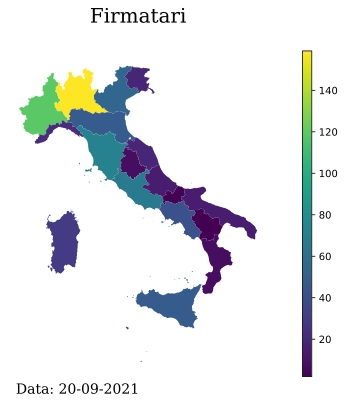

In [25]:
fig, ax = plt.subplots(1, figsize = (12, 6))

im = plot_df.plot(ax = ax, column = "Firmatari", cmap = "viridis", 
                  legend = True, categorical = False)

# --------------------------------------

ax.set_title("Firmatari\n", 
             fontdict = {"fontsize" : 20, "fontweight" : 1,
                         "fontname": "serif"}, 
             color = "Black")

ax.axis("off")
date_str = datetime.datetime.now().strftime('%d-%m-%Y')
ax.text(x = 3e5, y = 3.8e6, s = 'Data: %s'%(date_str), fontsize = 14, fontname = "serif")


# modify the colorbar
cax = fig.get_axes()[1]
cax.set_aspect(35)

# --------------------------------------

fig.savefig('firmatari.png', transparent = True, dpi = 300,
            bbox_inches = mpl.transforms.Bbox([[2, 0], [13, 6.5]]))

## Firmatari/Popolazione

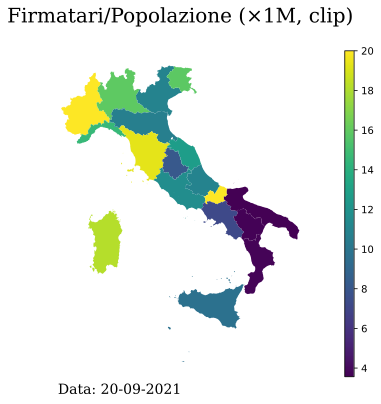

In [26]:
fig, ax = plt.subplots(1, figsize = (12, 6))

im = plot_df.plot(ax = ax, column = "Ratio_pop_scaled", cmap = "viridis", 
                  legend = True, categorical = False)

# --------------------------------------

ax.set_title("Firmatari/Popolazione (×1M, clip)\n", 
             fontdict = {"fontsize" : 20, "fontweight" : 1,
                         "fontname": "serif"}, 
             color = "Black")

ax.axis("off")
date_str = datetime.datetime.now().strftime('%d-%m-%Y')
ax.text(x = 3e5, y = 3.8e6, s = 'Data: %s'%(date_str), fontsize = 14, fontname = "serif")


# modify the colorbar
cax = fig.get_axes()[1]
cax.set_aspect(35)

# --------------------------------------

fig.savefig('firmatari_pop.png', transparent = True, dpi = 300,
            bbox_inches = mpl.transforms.Bbox([[2, 0], [13, 6.5]]))

## Firmatari/Personale Ateneo

Il Personale docente e ricercatore comprende i docenti di ruolo, i ricercatori a tempo indeterminato e determinato, i titolari di assegni di ricerca ed i docenti a contratto. Il personale docente a contratto comprende tutti i professori cui sono stati conferiti incarichi di insegnamento - anche a titolo gratuito - per attività formative di base, caratterizzanti, affini o integrative non già ricoperti dal personale docente di ruolo. Il Personale non docente comprende i tecnici - amministrativi, i dirigenti di prima e seconda fascia ed i collaboratori linguistici.

Fonte: [MIUR](http://ustat.miur.it/dati/didattica/italia/atenei#tabriepilogo)

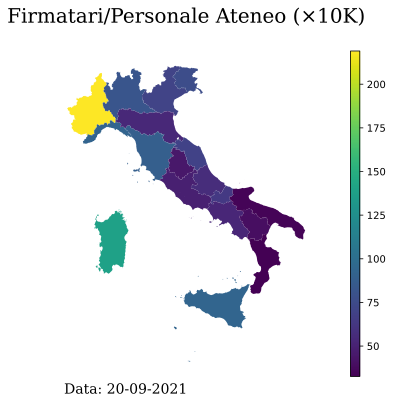

In [27]:
fig, ax = plt.subplots(1, figsize = (12, 6))

im = plot_df.plot(ax = ax, column = "Ratio_uni_scaled", cmap = "viridis", 
                  legend = True, categorical = False)

# --------------------------------------

ax.set_title("Firmatari/Personale Ateneo (×10K)\n", 
             fontdict = {"fontsize" : 20, "fontweight" : 1,
                         "fontname": "serif"}, 
             color = "Black")

ax.axis("off")
date_str = datetime.datetime.now().strftime('%d-%m-%Y')
ax.text(x = 3e5, y = 3.8e6, s = 'Data: %s'%(date_str), fontsize = 14, fontname = "serif")


# modify the colorbar
cax = fig.get_axes()[1]
cax.set_aspect(35)

# --------------------------------------

fig.savefig('firmatari_uni.png', transparent = True, dpi = 300,
            bbox_inches = mpl.transforms.Bbox([[2, 0], [13, 6.5]]))